# Comparação de Algumas Implementações dos NSGAs

## Parâmetros Globais do Notebook

Ajuste de localização dos módulos que implementam o NSGA-II e NSGA-III

In [1]:
import sys
import os

# Adiciona o diretório base ao sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # Ajuste conforme a localização do notebook
if project_path not in sys.path:
    sys.path.insert(0, project_path)


Funções Objetivo

In [2]:
def func1_2d(x):
    return x[0]**2

def func2_2d(x):
    return (x[0] - 2)**2

Parâmetros para execução dos algoritmos

In [3]:
bounds_2d = [(-5, 5)]
functions_2d = [func1_2d, func2_2d]
NUM_GEN = 16
POP_SIZE = 52

Operadores Genéticos

In [4]:
import random
import numpy as np

def simple_crossover(parent1, parent2):
    w = random.uniform(0, 1)
    child1 = w*parent1 + (1-w)*parent2
    w = random.uniform(0, 1)
    child2 = w*parent1 + (1-w)*parent2
    return (child1, child2)

def simple_mutation(individual, bounds):
    if random.random() < 0.5: # mutation rate
        for i in range(len(individual)):
            individual[i] += random.uniform(-0.1, 0.1)
            individual[i] = np.clip(individual[i], bounds[i][0], bounds[i][1])
    return individual


População inicial

In [5]:
import random
import numpy as np

initial_population = [
            np.array([random.uniform(b[0], b[1]) for b in bounds_2d])
            for _ in range(POP_SIZE)
        ]

Função de plot dos gráficos de resultados

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_solutions(pareto_front):
    """
    Plota gráficos paralelos lado a lado e o gráfico de dispersão da fronteira de Pareto para 2 objetivos.
    
    :param pareto_front: Lista ou array de pontos da fronteira de Pareto em 2D.
    """
    # Normalizar os valores dos objetivos para [0, 1]
    def normalize(solutions):
        solutions = np.array(solutions)
        return (solutions - solutions.min(axis=0)) / (solutions.max(axis=0) - solutions.min(axis=0))

    # Normalizar as soluções
    normalized_solutions = normalize(pareto_front)

    # Configuração dos subgráficos
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico paralelo 1
    for sol in normalized_solutions:
        axes[0].plot(np.arange(normalized_solutions.shape[1]), sol, marker='o', alpha=0.7)
    axes[0].set_xticks(np.arange(normalized_solutions.shape[1]))
    axes[0].set_xticklabels([f"Objetivo {i+1}" for i in range(normalized_solutions.shape[1])])
    axes[0].set_xlabel("Objetivos")
    axes[0].set_ylabel("Valores Normalizados")
    axes[0].set_title("Gráfico Paralelo - Soluções Normalizadas")
    axes[0].grid(alpha=0.3)

    # Gráfico de dispersão da fronteira de Pareto
    axes[1].scatter(*zip(*pareto_front), label='Fronteira de Pareto', color='blue', alpha=0.7)
    axes[1].set_xlabel("f1(x)")
    axes[1].set_ylabel("f2(x)")
    axes[1].set_title("Fronteira de Pareto - Caso com 2 Objetivos")
    axes[1].grid(alpha=0.3)
    axes[1].axis("equal")
    axes[1].legend()

    # Ajustar layout
    plt.tight_layout()
    plt.show()

## Minha implementação NSGA-II

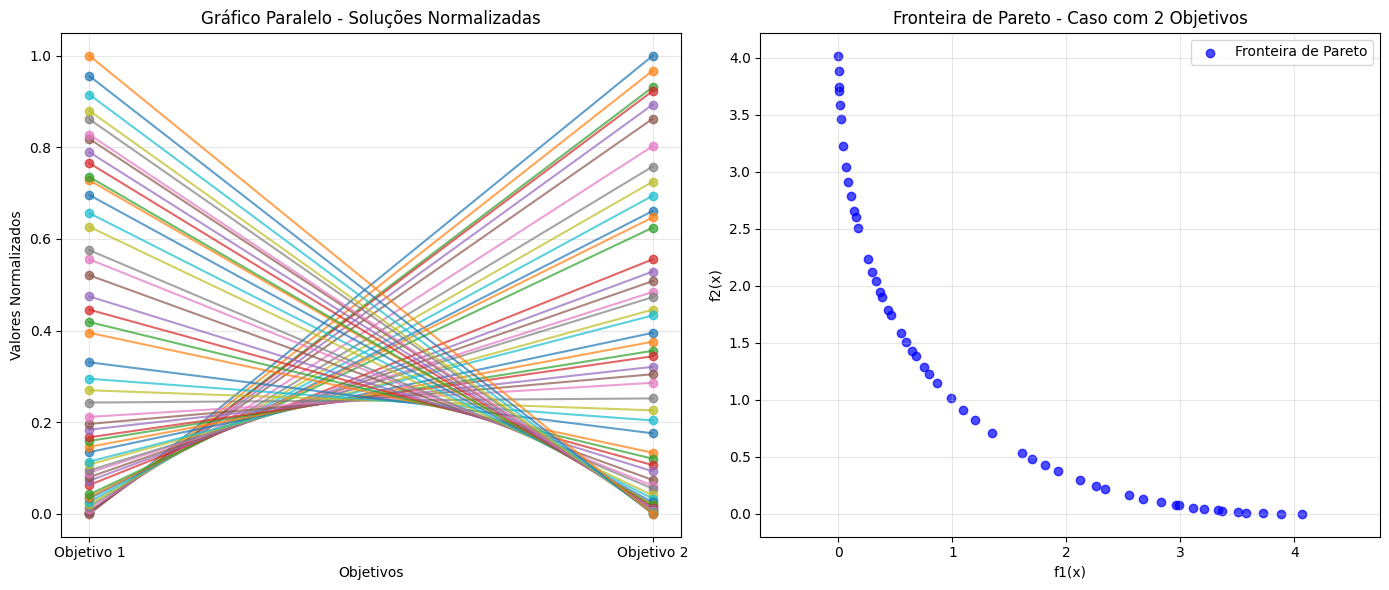

In [7]:
from modules.nsga2 import nsga2_func

pareto_front_my_nsga2 = nsga2_func(
    POP_SIZE, 
    NUM_GEN, 
    bounds_2d, 
    functions_2d, 
    simple_crossover, 
    simple_mutation,
    initial_population)

plot_solutions(pareto_front_my_nsga2)

## Minha Implementação NSGA-III

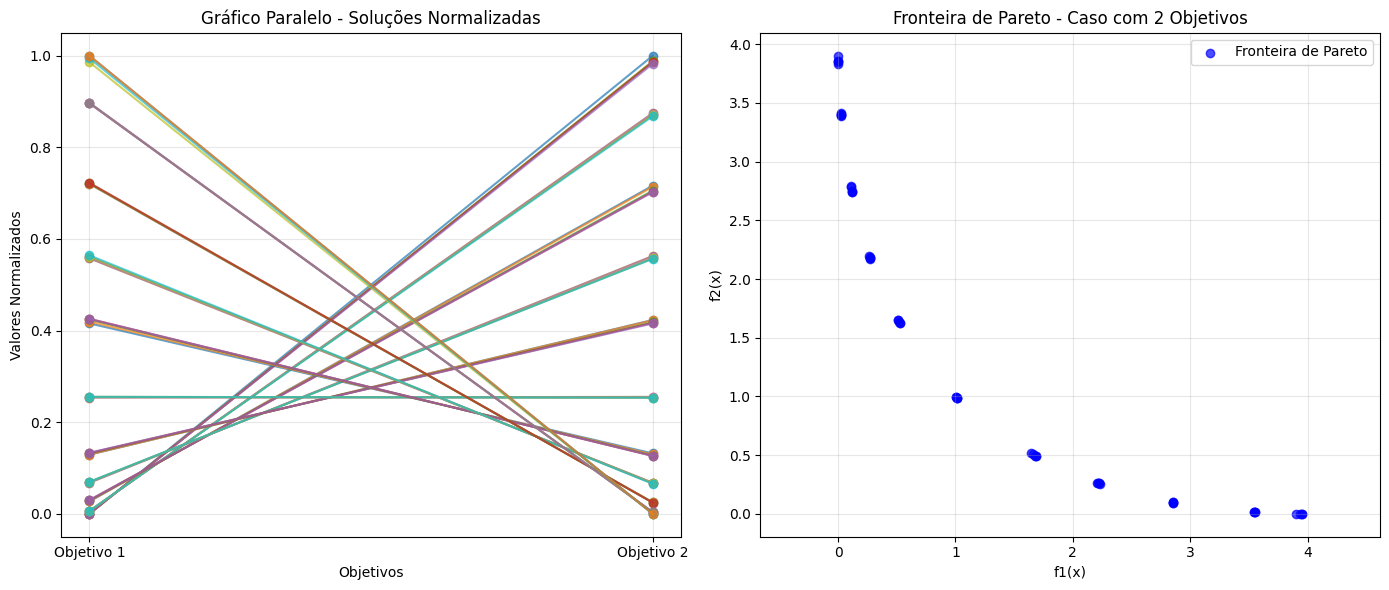

In [8]:
from modules.nsga3 import nsga3_func

pareto_front_my_nsga3 = nsga3_func(
    POP_SIZE, 
    NUM_GEN, 
    bounds_2d, 
    functions_2d, 
    simple_crossover, 
    simple_mutation,
    initial_population)

plot_solutions(pareto_front_my_nsga3)

## Usando Pymoo

In [9]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.core.problem import Problem
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.population import Population
from pymoo.optimize import minimize
import numpy as np
from typing import Callable
    
def nsga3_pymoo_func(
    pop_size: int,
    generations: int,
    bounds: list[tuple[float, float]],
    functions: list[Callable[[np.ndarray], float]],
    crossover: Callable[[np.ndarray, np.ndarray], tuple[np.ndarray,np.ndarray]],
    mutation: Callable[[np.ndarray, list[tuple[float, float]]], np.ndarray],
    initial_pop: list[np.ndarray] = None,
    divisions: int = 10,
    ref_points: np.ndarray = None
) -> list[tuple[float, ...]]:
    """
    Utiliza PyMoo para resolver o NSGA-III com os parâmetros especificados.
    """    
    # Número de objetivos e variáveis de decisão
    n_obj = len(functions)
    n_var = len(bounds)

    # Definir o problema personalizado para PyMoo
    class CustomProblem(Problem):
        def __init__(self):
            super().__init__(n_var=n_var, 
                             n_obj=n_obj, 
                             xl=np.array([b[0] for b in bounds]), 
                             xu=np.array([b[1] for b in bounds]))
        
        def _evaluate(self, x, out, *args, **kwargs):
            out["F"] = np.array([[f(ind) for f in functions] for ind in x])

    problem = CustomProblem()

    # Direções de referência para NSGA-III
    if ref_points is None:
        ref_points = get_reference_directions("das-dennis", n_dim=n_obj, n_partitions=divisions)

    # Configurar operadores personalizados
    class CustomCrossover(Crossover):
        def __init__(self, func: Callable[[np.ndarray, np.ndarray], np.ndarray]):
            super().__init__(n_parents=2, n_offsprings=2)
            self.func = func

        def _do(self, problem, X, **kwargs):
            children = self.func(X[0], X[1])
            # Converte a lista de filhos para um array NumPy
            return np.array(children)

    crossover_operator = CustomCrossover(crossover)
    
    class CustomMutation(Mutation):
        def __init__(self, func: Callable[[np.ndarray, list[tuple[float, float]]], np.ndarray], bounds: list[tuple[float, float]]):
            super().__init__()
            self.func = func
            self.bounds = bounds

        def _do(self, problem, X, **kwargs):
            return np.array([self.func(ind, self.bounds) for ind in X])
    
    mutation_operator = CustomMutation(mutation, bounds)

    # Configuração inicial da população, se fornecida
    initial_population = None
    if initial_pop:
        initial_population = Population.new("X", np.array(initial_pop))

    # Configurar algoritmo NSGA-III
    algorithm = NSGA3(
        pop_size=pop_size,
        ref_dirs=ref_points,
        crossover=crossover_operator,
        mutation=mutation_operator,
    )

    # Resolver o problema
    result = minimize(
        problem,
        algorithm,
        termination=('n_gen', generations),
        seed=1,
        verbose=False,
        save_history=False,
        initial_population=initial_population,
    )

    # Extrair a solução
    pareto_front = [tuple(ind) for ind in result.F]

    return pareto_front



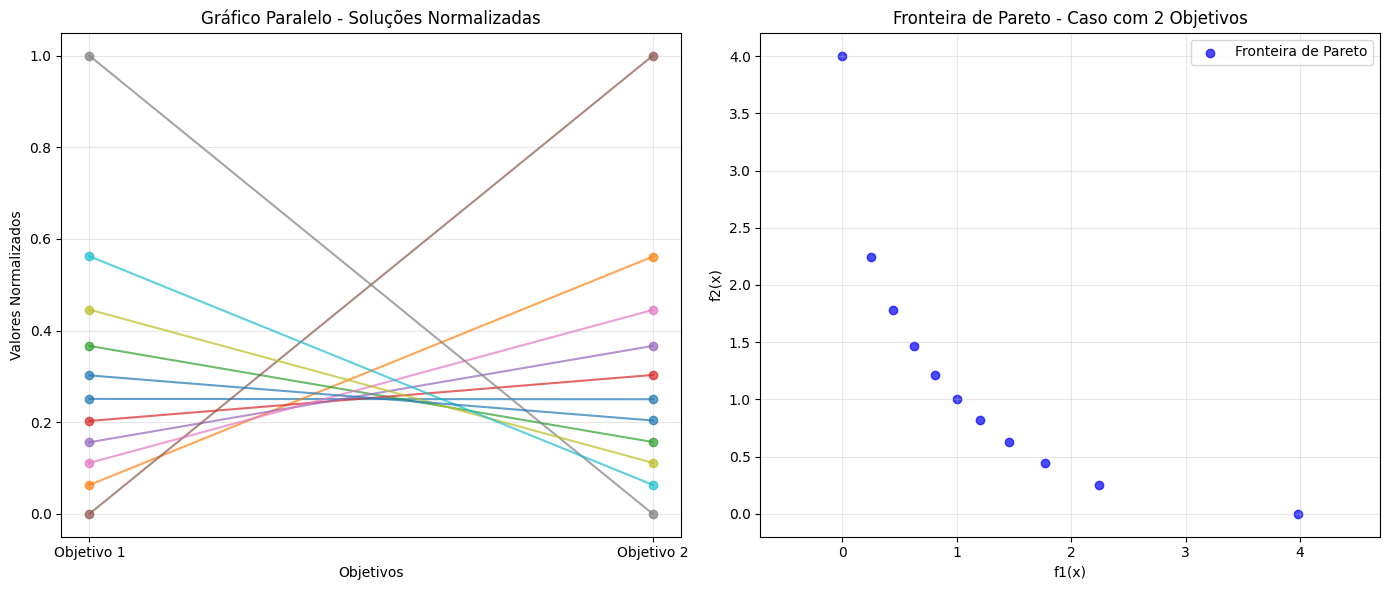

In [14]:
pareto_front_pymoo_nsga3 = nsga3_pymoo_func(
    POP_SIZE, 
    NUM_GEN, 
    bounds_2d, 
    functions_2d, 
    simple_crossover, 
    simple_mutation,
    initial_population)

plot_solutions(pareto_front_pymoo_nsga3)

## Usando DEAP

In [11]:
from deap import base, creator, tools
import numpy as np
from typing import Callable

def nsga3_deap_func(
    pop_size: int,
    generations: int,
    bounds: list[tuple[float, float]],
    functions: list[Callable[[np.ndarray], float]],
    crossover: Callable[[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]],
    mutation: Callable[[np.ndarray, list[tuple[float, float]]], np.ndarray],
    initial_pop: list[np.ndarray] = None,
    divisions: int = 10,
    ref_points: np.ndarray = None
) -> list[tuple[float, ...]]:
    """
    Utiliza DEAP para resolver NSGA-II com os parâmetros especificados.
    """
    # Número de objetivos e variáveis de decisão
    n_obj = len(functions)
    n_var = len(bounds)

    # Criação dos tipos básicos para DEAP
    creator.create("FitnessMulti", base.Fitness, weights=(-1.0,) * n_obj)
    creator.create("Individual", list, fitness=creator.FitnessMulti)

    toolbox = base.Toolbox()

    # Inicializador de indivíduos
    toolbox.register(
        "attr_float",
        lambda low, up: np.random.uniform(low, up),
        [b[0] for b in bounds],
        [b[1] for b in bounds],
    )
    toolbox.register(
        "individual",
        lambda: creator.Individual(
            [np.random.uniform(b[0], b[1]) for b in bounds]
        ),
    )
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Avaliação personalizada
    def evaluate(individual):
        return tuple(f(np.array(individual)) for f in functions)

    toolbox.register("evaluate", evaluate)

    # Geração dos pontos de referência para o NSGA-III
    if ref_points is None:
        ref_points = tools.uniform_reference_points(nobj=2, p=divisions)
        
    # Crossover personalizado
    def custom_crossover(ind1, ind2):
        child1, child2 = crossover(np.array(ind1), np.array(ind2))
        return creator.Individual(child1.tolist()), creator.Individual(child2.tolist())

    toolbox.register("mate", custom_crossover)

    # Mutação personalizada
    def custom_mutation(individual):
        mutated = mutation(np.array(individual), bounds)
        individual[:] = mutated.tolist()
        return individual

    toolbox.register("mutate", custom_mutation)

    # Operador de seleção
    toolbox.register("select", tools.selNSGA3)

    # Inicialização da população
    if initial_pop:
        population = [creator.Individual(ind.tolist()) for ind in initial_pop]
    else:
        population = toolbox.population(n=pop_size)

    # Estatísticas
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min, axis=0)
    stats.register("avg", np.mean, axis=0)

    CXPB = 0.9  # Probabilidade de crossover
    MUTPB = 0.1  # Probabilidade de mutação
    
    # Avaliação inicial da população
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
    # Loop evolutivo
    for gen in range(generations):
        # Seleção dos indivíduos
        offspring = toolbox.select(population, len(population), ref_points=ref_points)

        # Clonagem dos indivíduos selecionados
        offspring = list(map(toolbox.clone, offspring))

        # Aplicação do crossover e mutação
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                ind1, ind2 = toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for ind in offspring:
            if random.random() < MUTPB:
                ind = toolbox.mutate(ind)
                del ind.fitness.values

        # Reavaliação dos indivíduos
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Atualização da população
        population = offspring

    # Retornar a frente de Pareto
    pareto_front = [tuple(ind.fitness.values) for ind in tools.sortNondominated(population, len(population), first_front_only=True)[0]]
    
        
    return pareto_front


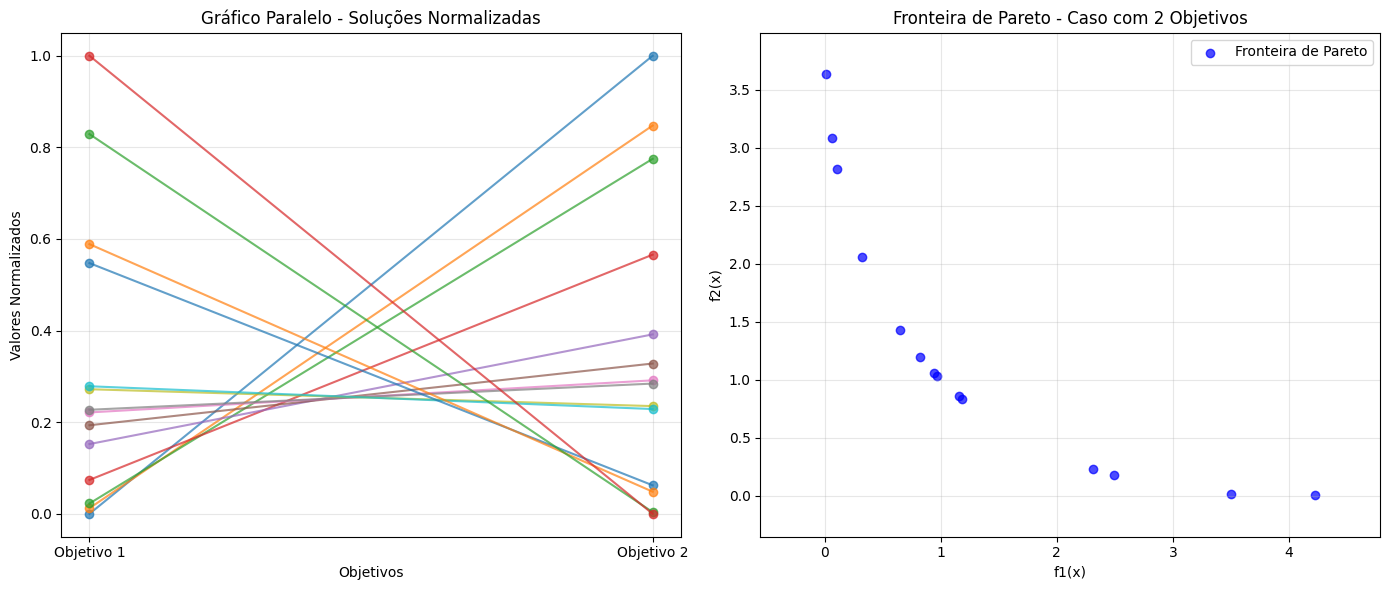

In [12]:
pareto_front_deap_nsga3 = nsga3_deap_func(
    POP_SIZE, 
    NUM_GEN, 
    bounds_2d, 
    functions_2d, 
    simple_crossover, 
    simple_mutation,
    initial_population)

plot_solutions(pareto_front_deap_nsga3)

### Comparação entre os Resultados Obtidos nos Blocos Anteriores

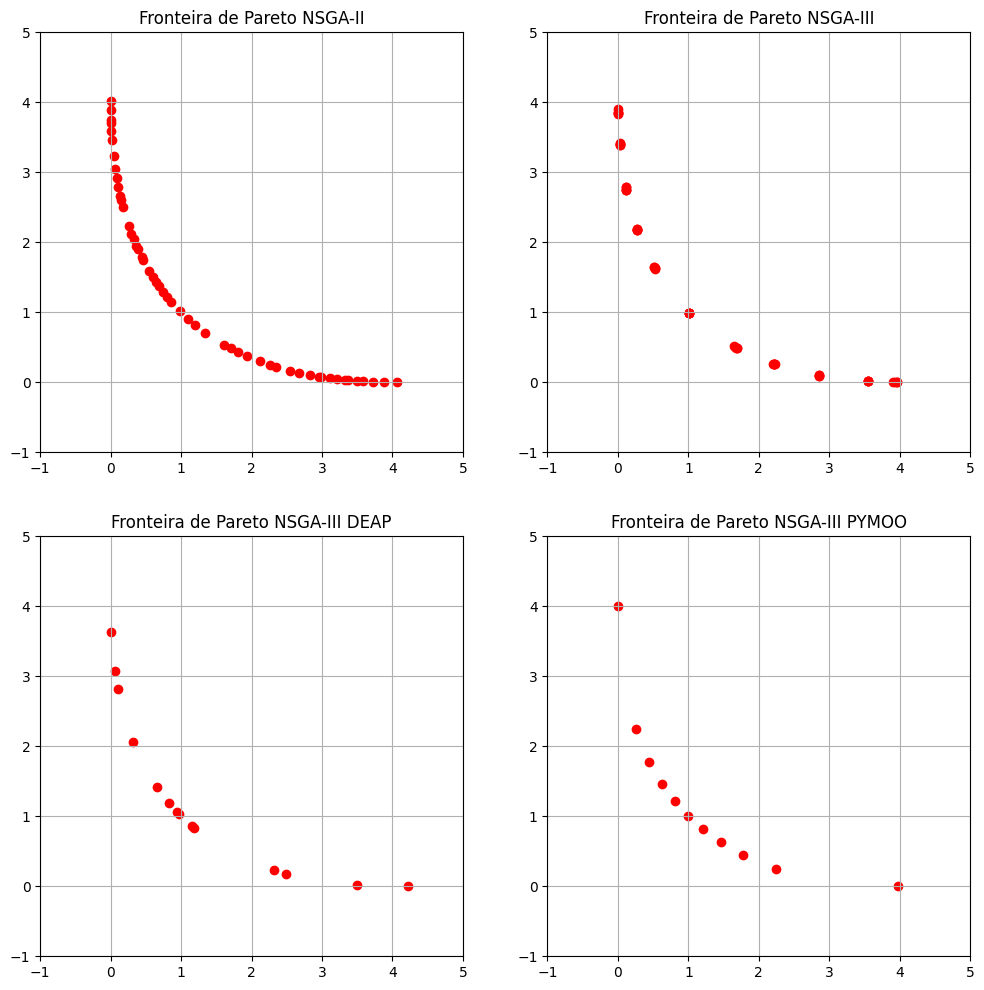

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

def plot(pareto_front, pos, text):
    plt.subplot(2, 2, pos)
    plt.scatter(*zip(*pareto_front), color="red")
    plt.title(f"Fronteira de Pareto {text}")
    plt.grid()
    plt.xticks(np.arange(-1, 6, 1)) 
    plt.yticks(np.arange(-1, 6, 1)) 
    plt.xlim([-1, 5])
    plt.ylim([-1, 5])

plot(pareto_front_my_nsga2, 1, "NSGA-II")
plot(pareto_front_my_nsga3, 2, "NSGA-III")
plot(pareto_front_deap_nsga3, 3, "NSGA-III DEAP")
plot(pareto_front_pymoo_nsga3, 4, "NSGA-III PYMOO")